In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
import sys, os, pathlib
import numpy as np
import torch

import warp as wp
wp.config.quiet = True
wp.set_device('cpu')

sys.path.append('../..')
import project
from project.core.utils import pprint

torch.cuda.is_available()

True

In [3]:
!nvidia-smi

Wed Jan 28 11:26:35 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A6000               On  |   00000000:61:00.0 Off |                  Off |
| 30%   26C    P8             16W /  300W |     294MiB /  49140MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [4]:
config = project.core.fileio.load_config('2026-01-15_config.yaml')
config['dataset']['examples']['subjects'] = '/ocean/projects/asc170022p/mtragoza/lung-project/notebooks/shapenet/2026-01-26_preprocessed.csv'
config['dataset']

Loading 2026-01-15_config.yaml


{'name': 'ShapeNet',
 'root': '/ocean/projects/asc170022p/mtragoza/lung-project/data/ShapeNetSem',
 'examples': {'subjects': '/ocean/projects/asc170022p/mtragoza/lung-project/notebooks/shapenet/2026-01-26_preprocessed.csv',
  'variant': '2026-01-15'},
 'metadata': {'parse_metadata': True,
  'unit_policy': 'prefer_metadata',
  'default_unit': 0.01},
 'selectors': {'material_mask': 'uniform-seed'}}

In [5]:
config['preprocessing']['image_generation']['texture_source']

{'annotations': '/ocean/projects/asc170022p/mtragoza/lung-project/notebooks/shapenet/2025-11-20_annotations.csv',
 'use_solid': True,
 'iqr_mult': 4.0}

In [6]:
import project.preprocessing.textures

tex_cache = project.preprocessing.textures.TextureCache(
    **config['preprocessing']['image_generation']['texture_source']
)
tex_cache

In [7]:
def make_grid_points(size):
    return np.stack(np.mgrid[0:size,0:size,0:size], axis=-1).reshape(-1, 3)

size = 128
points = make_grid_points(128)
points

array([[  0,   0,   0],
       [  0,   0,   1],
       [  0,   0,   2],
       ...,
       [127, 127, 125],
       [127, 127, 126],
       [127, 127, 127]], shape=(2097152, 3))

In [8]:
import project.visual.matplotlib as mpl_viz
rng = np.random.default_rng(0)

Loading /ocean/projects/asc170022p/mtragoza/SolidTextureNets/Trained/80703cf49d2a14c5.nii
Loading /ocean/projects/asc170022p/mtragoza/SolidTextureNets/Trained/e99e6b2fa82e040a.nii
Loading /ocean/projects/asc170022p/mtragoza/SolidTextureNets/Trained/17fababfd85461d1.nii
Loading /ocean/projects/asc170022p/mtragoza/SolidTextureNets/Trained/b25c0f2ee0edc563.nii
Loading /ocean/projects/asc170022p/mtragoza/SolidTextureNets/Trained/a6c66d0eeaca8c03.nii


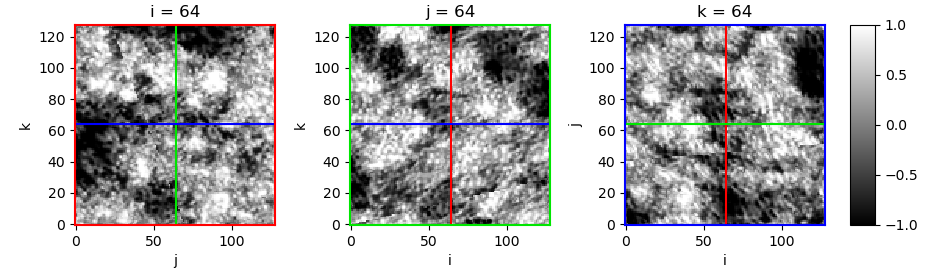

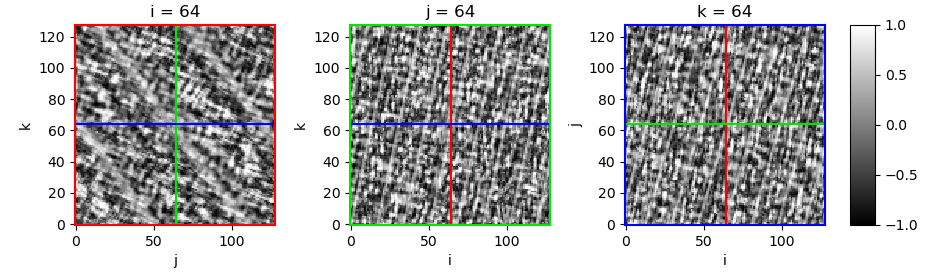

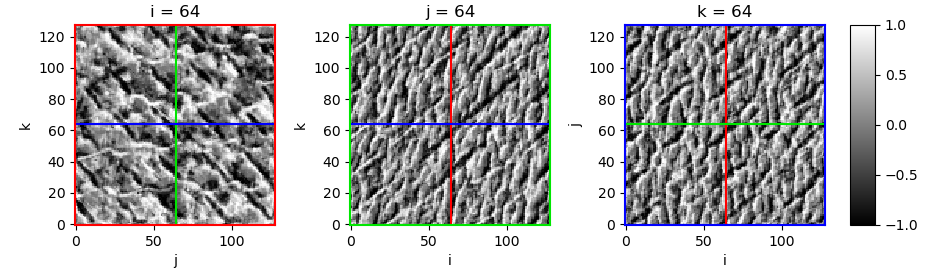

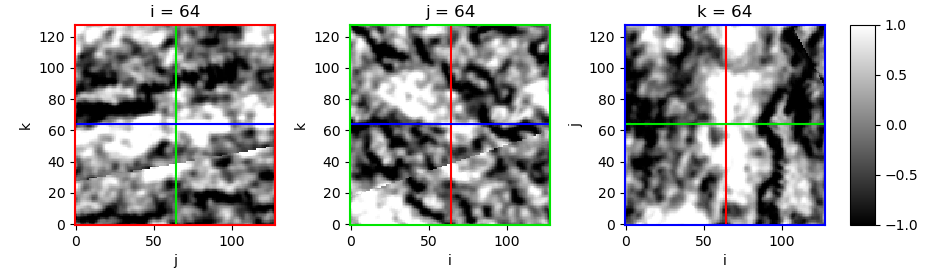

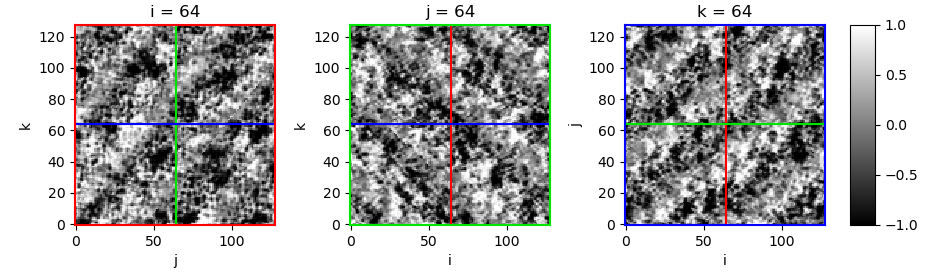

In [9]:
tex_types = ['paper', 'fabric', 'leather', 'marble', 'stone']
for tex_type in tex_types:
    patch = tex_cache.sample_field(tex_type, points, rng).reshape(size, size, size)
    _ = mpl_viz.show_image_slices(patch, cmap='gray', clim=(-1, 1))

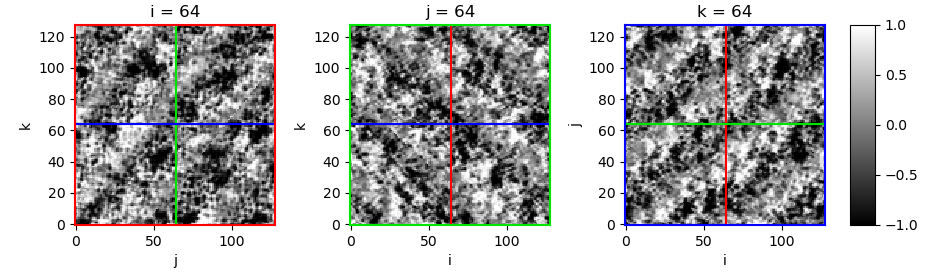

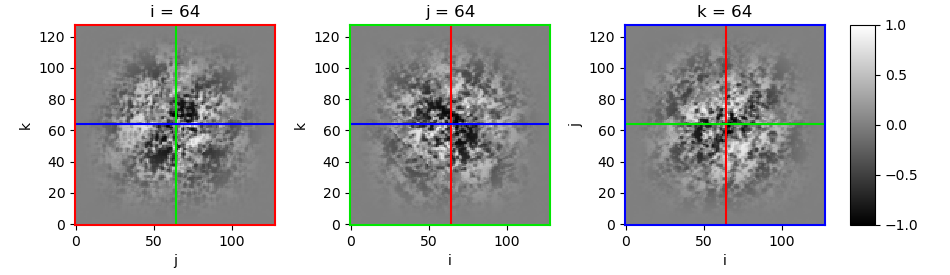

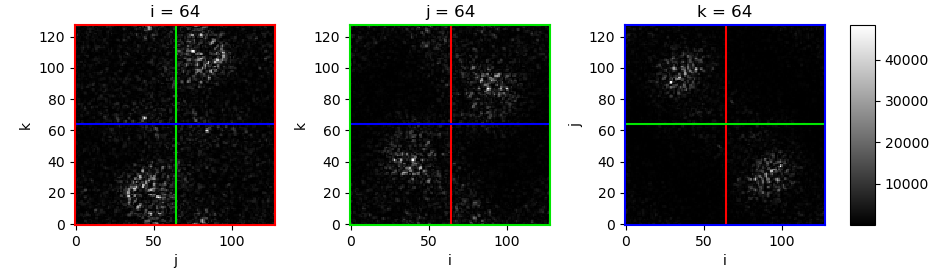

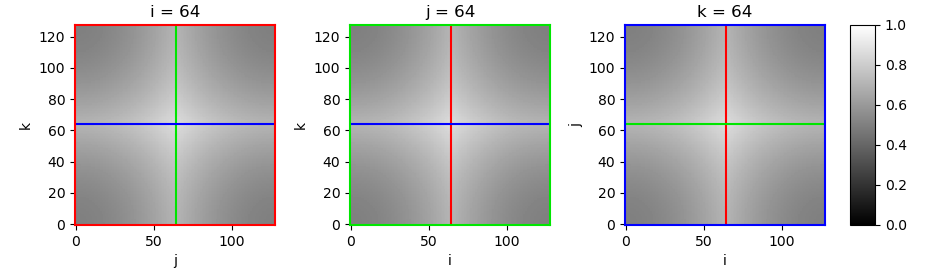

In [11]:
x = patch

_ = mpl_viz.show_image_slices(x, cmap='gray', clim=(-1, 1))

x = x - x.mean()

# apply Hanning window
wx = np.hanning(x.shape[0])
wy = np.hanning(x.shape[1])
wz = np.hanning(x.shape[2])
w3 = wx[:,None,None] * wy[None,:,None] * wz[None,None,:]
x = x * w3

_ = mpl_viz.show_image_slices(x, cmap='gray', clim=(-1, 1))

F = np.fft.fftn(x)
P = (F.real**2 + F.imag**2)

_ = mpl_viz.show_image_slices(P, cmap='gray') #, clim=(-1, 1))

kx = np.fft.fftfreq(x.shape[0])[:,None,None]
ky = np.fft.fftfreq(x.shape[1])[None,:,None]
kz = np.fft.fftfreq(x.shape[2])[None,None,:]

k = np.sqrt(kx*kx + ky*ky + kz*kz)

_ = mpl_viz.show_image_slices(k, cmap='gray', clim=(0, 1))

In [12]:
def power_spectrum(
    vol,
    bins=64,
    binning='linear',
    center=True,
    window=False,
    eps=1e-12
):
    x = np.asarray(vol, dtype=np.float64)

    if center:
        x = x - x.mean()

    if window:
        wx = np.hanning(x.shape[0])
        wy = np.hanning(x.shape[1])
        wz = np.hanning(x.shape[2])
        w3 = wx[:,None,None] * wy[None,:,None] * wz[None,None,:]
        x = x * w3

    F = np.fft.fftn(x)
    P = (F.real**2 + F.imag**2)

    # spatial frequency coordinates
    kx = np.fft.fftfreq(x.shape[0])[:,None,None]
    ky = np.fft.fftfreq(x.shape[1])[None,:,None]
    kz = np.fft.fftfreq(x.shape[2])[None,None,:]

    # radial frequency magnitude
    k = np.sqrt(kx*kx + ky*ky + kz*kz)

    k_flat = k.ravel()
    P_flat = P.ravel()

    if binning == 'linear':
        k_min = 0.0
        k_max = k_flat.max()
        edges = np.linspace(k_min, k_max + eps, bins + 1)

    elif binning == 'log':
        k_pos = k_flat[k_flat > 0]
        k_min = k_pos.min()
        k_max = k_pos.max()
        edges = np.geomspace(k_min, k_max + eps, bins + 1)
        edges = np.concatenate([[0.0], edges])
        bins = len(edges) - 1

    # bin assignment
    idx = np.digitize(k_flat, edges) - 1
    idx = np.clip(idx, 0, bins - 1)

    P_k = np.bincount(idx, weights=P_flat, minlength=bins).astype(np.float64)
    counts = np.bincount(idx, minlength=bins).astype(np.float64)
    P_k = P_k / np.maximum(counts, 1.0)

    k_centers = 0.5 + (edges[:-1] + edges[1:])

    return k_centers, P_k

power_spectrum(patch)

(array([0.51353165, 0.54059494, 0.56765823, 0.59472153, 0.62178482,
        0.64884812, 0.67591141, 0.7029747 , 0.730038  , 0.75710129,
        0.78416459, 0.81122788, 0.83829117, 0.86535447, 0.89241776,
        0.91948105, 0.94654435, 0.97360764, 1.00067094, 1.02773423,
        1.05479752, 1.08186082, 1.10892411, 1.13598741, 1.1630507 ,
        1.19011399, 1.21717729, 1.24424058, 1.27130388, 1.29836717,
        1.32543046, 1.35249376, 1.37955705, 1.40662034, 1.43368364,
        1.46074693, 1.48781023, 1.51487352, 1.54193681, 1.56900011,
        1.5960634 , 1.6231267 , 1.65018999, 1.67725328, 1.70431658,
        1.73137987, 1.75844316, 1.78550646, 1.81256975, 1.83963305,
        1.86669634, 1.89375963, 1.92082293, 1.94788622, 1.97494952,
        2.00201281, 2.0290761 , 2.0561394 , 2.08320269, 2.11026599,
        2.13732928, 2.16439257, 2.19145587, 2.21851916]),
 array([5.18818268e+07, 2.98535418e+08, 4.34476870e+08, 9.19340725e+07,
        7.22970773e+07, 3.67101098e+07, 2.56199306e+07

In [13]:
def collect_class_spectra(tex_cache, tex_types, patch_size=32, sample_size=20, seed=0):
    rng = np.random.default_rng(seed)
    points = make_grid_points(patch_size)
    spectra = {t: [] for t in tex_types}
    for t in tex_types:
        print(t)
        for i in range(sample_size):
            p = tex_cache.sample_field(t, points, rng)
            p = p.reshape(patch_size, patch_size, patch_size)
            k, P_k = power_spectrum(p, bins=64, binning='linear', window=True, center=True)
            P_k = P_k / (P_k.sum() + 1e-12)
            spectra[t].append(P_k)

    # stack (sample_size, bins)
    spectra = {t: np.stack(v, axis=0) for t, v in spectra.items()}
    return k, spectra

tex_types = ['paper', 'fabric', 'leather', 'marble', 'stone']
k, spectra = collect_class_spectra(tex_cache, tex_types)

paper
fabric
leather
marble
stone


(0.5, 1.5)

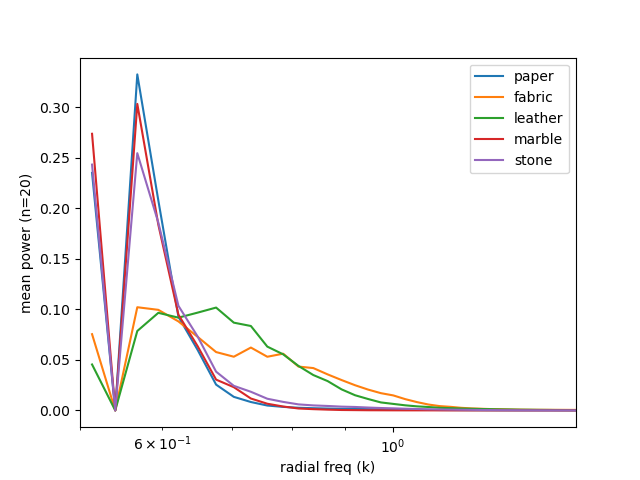

In [14]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

for t in tex_types:
    ax.plot(k, spectra[t].mean(axis=0), label=t)

ax.set_ylabel('mean power (n=20)')
ax.set_xlabel('radial freq (k)')
ax.legend()
ax.set_xscale('log')
ax.set_xlim(0.5, 1.5)

In [20]:
import torch

class TexturePatchDataset(torch.utils.data.Dataset):

    def __init__(self, tex_cache, tex_types, patch_size=32, n_per_type=100, seed=0):
        self.tex_cache = tex_cache
        self.tex_types = tex_types
        self.patch_size = patch_size

        self.points = make_grid_points(patch_size)
        self.items = [
            (i, j) for i in range(len(tex_types)) for j in range(n_per_type)
        ]
        self.rng = np.random.default_rng(seed)

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        i, j = self.items[idx]
        patch = self.tex_cache.sample_field(self.tex_types[i], self.points, self.rng)
        patch = patch.reshape(self.patch_size, self.patch_size, self.patch_size)
        return torch.as_tensor(patch, dtype=torch.float).unsqueeze(0), torch.tensor(i)

ds = TexturePatchDataset(tex_cache, tex_types, patch_size=32)

In [21]:
class ImagePatchDataset(torch.utils.data.Dataset):

    def __init__(self, tex_cache, tex_types, patch_size=32, n_per_type=100, seed=0):
        self.tex_cache = tex_cache
        self.tex_types = tex_types
        self.patch_size = patch_size

        self.points = make_grid_points(patch_size)
        self.items = [
            (i, j) for i in range(len(tex_types)) for j in range(n_per_type)
        ]
        self.rng = np.random.default_rng(seed)

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        i, j = self.items[idx]
        patch = self.tex_cache.sample_field(self.tex_types[i], self.points, self.rng)
        patch = patch.reshape(self.patch_size, self.patch_size, self.patch_size)
        return torch.as_tensor(patch, dtype=torch.float).unsqueeze(0), torch.tensor(i)

ds = TexturePatchDataset(tex_cache, tex_types)

In [32]:
class CNN(torch.nn.Module):

    def __init__(self, n_out):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Conv3d(1, 16, 3, padding=1), torch.nn.LeakyReLU(), torch.nn.MaxPool3d(2),
            torch.nn.Conv3d(16, 32, 3, padding=1), torch.nn.LeakyReLU(), torch.nn.MaxPool3d(2),
            torch.nn.AdaptiveAvgPool3d(1), torch.nn.Flatten(), torch.nn.Linear(32, n_out)
        )

    def forward(self, x):
        return self.net(x)

CNN(n_out=5)

CNN(
  (net): Sequential(
    (0): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (4): LeakyReLU(negative_slope=0.01)
    (5): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): AdaptiveAvgPool3d(output_size=1)
    (7): Flatten(start_dim=1, end_dim=-1)
    (8): Linear(in_features=32, out_features=5, bias=True)
  )
)

In [33]:
def train_classifier(ds, batch_size=8, lr=1e-3, epochs=10, device='cuda'):

    N = len(ds)
    n = int(0.8 * N)
    t_set, v_set = torch.utils.data.random_split(ds, [n, N - n])
    
    t_loader = torch.utils.data.DataLoader(t_set, batch_size=batch_size, shuffle=True)
    v_loader = torch.utils.data.DataLoader(v_set, batch_size=batch_size, shuffle=True)
    
    model = CNN(n_out=5).to(device)
    lossf = torch.nn.CrossEntropyLoss()
    optim = torch.optim.AdamW(model.parameters(), lr=lr)

    for ep in range(epochs):
        model.train()
    
        loss_n = loss_d = 0
        tacc_n = tacc_d = 0
        vacc_n = vacc_d = 0
    
        for x, y in t_loader:
            x, y = x.to(device), y.to(device)
            optim.zero_grad()
            yp = model(x)
            loss = lossf(yp, y)
            loss.backward()
            optim.step()
            
            loss_n += loss.item() * x.size(0)
            loss_d += x.size(0)
    
            tacc_n += (yp.argmax(1) == y).sum().item()
            tacc_d += y.numel()
    
        with torch.no_grad():
            for x, y in v_loader:
                x, y = x.to(device), y.to(device)
                yp = model(x)
    
                vacc_n += (yp.argmax(1) == y).sum().item()
                vacc_d += y.numel()

        loss = loss_n / loss_d
        tacc = tacc_n / tacc_d
        vacc = vacc_n / vacc_d
        
        print(f'epoch {ep+1} | loss = {loss:.4f} acc_t = {tacc:.4f} acc_v = {vacc:.4f}')

train_classifier(ds)

epoch 1 | loss = 1.4947 acc_t = 0.2750 acc_v = 0.3700
epoch 2 | loss = 1.1267 acc_t = 0.5975 acc_v = 0.6100
epoch 3 | loss = 0.8340 acc_t = 0.7400 acc_v = 0.8100
epoch 4 | loss = 0.6604 acc_t = 0.8200 acc_v = 0.7400
epoch 5 | loss = 0.5193 acc_t = 0.8400 acc_v = 0.9800
epoch 6 | loss = 0.3953 acc_t = 0.9425 acc_v = 0.9900
epoch 7 | loss = 0.3122 acc_t = 0.9825 acc_v = 0.9500
epoch 8 | loss = 0.2526 acc_t = 0.9600 acc_v = 0.9500
epoch 9 | loss = 0.2325 acc_t = 0.9625 acc_v = 0.9500
epoch 10 | loss = 0.1839 acc_t = 0.9800 acc_v = 0.9900
